Implementing LSTM model for a course slots prediction based on a sequential data for Informatics Engineering (INNI) on CUCEI.

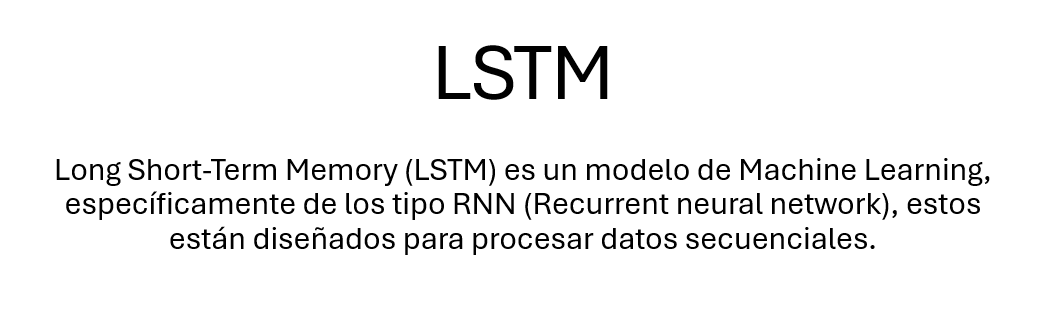

In [40]:
# === Imports base y semilla 42 para reproducibilidad ===
import random, numpy as np, pandas as pd, tensorflow as tf, importlib, os

from sklearn.preprocessing import LabelEncoder, StandardScaler

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


import comparation2
importlib.reload(comparation2)
import Resumir_Datasets
importlib.reload(Resumir_Datasets)
import unionDatasets
importlib.reload(unionDatasets)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [41]:

#Resumen por semestre desde 'datasets_originales/*.xlsx'
Resumir_Datasets.resumir_datasets()  # genera 'datasets_resumidos/resumen_cupos_*.xlsx'


Archivo generado: datasets_resumidos\resumen_cupos_2013A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2013B.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2014A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2014B.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2015A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2015B.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2016A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2016B.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2017A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2017B.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2018A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2018B.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2019A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2019B.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2020A.xlsx
Archivo generado: datasets_resumidos\resumen_cupos_2020B.xlsx
Archivo 

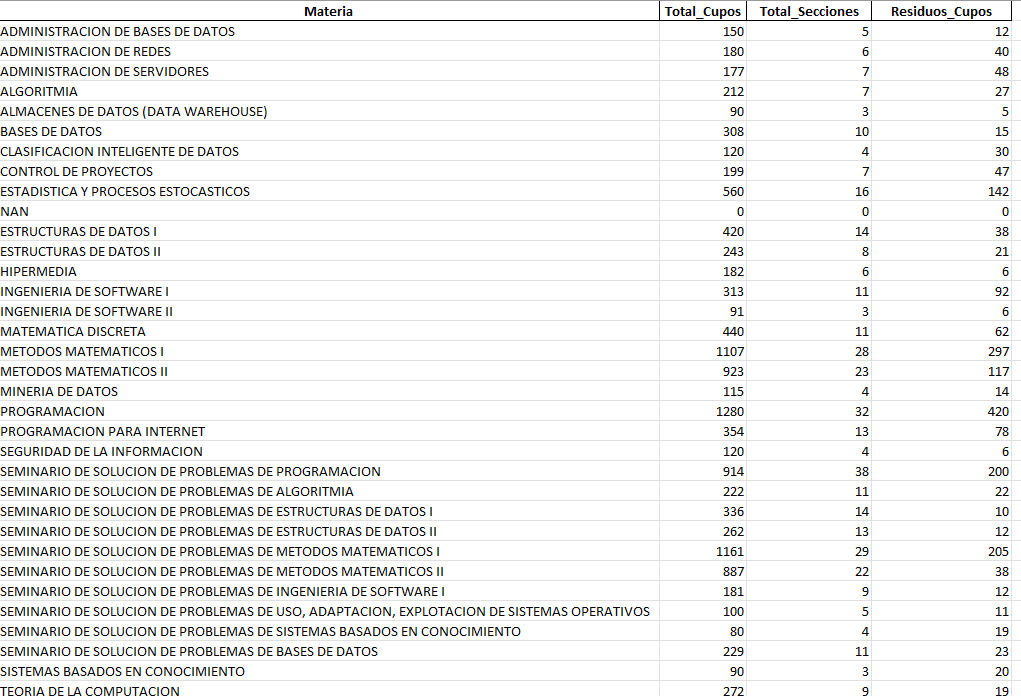

In [42]:
# 2) Unifica y enriquece (semestres, lag, ingresos, etc.)
unionDatasets.union_Datasets()    # genera 'oferta_academica_unificada.csv' con columnas clave

Iniciando la función de unificación
Archivo guardado como 'oferta_academica_unificada.csv'
Filas: 773 | Columnas: 9
Columnas: ['Materia', 'Total_Cupos', 'Total_Secciones', 'Residuos_Cupos', 'semestre_numerico', 'semestre_original', 'cupos_usados', 'nuevos_alumnos', 'lag1_cupos_usados']
Función de unificación ejecutada con éxito


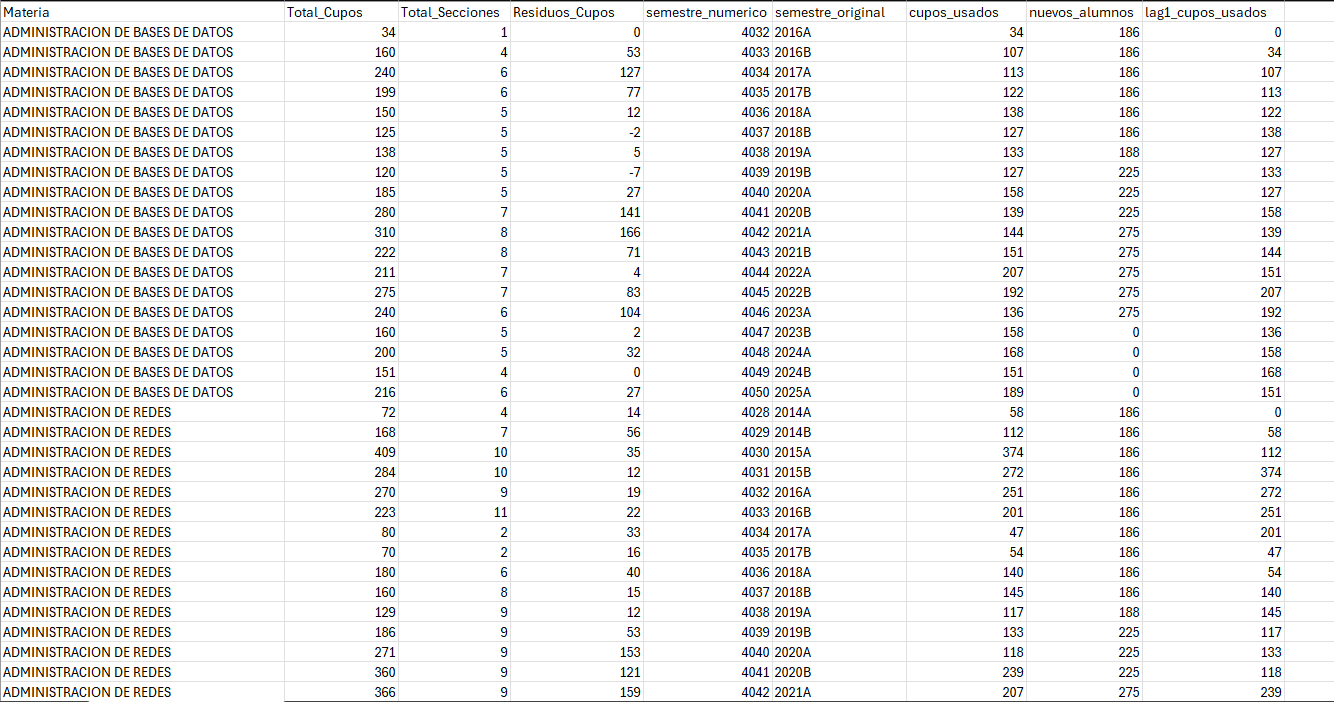

In [43]:
# Carga el histórico ya unificado y recortado a t−1 (tu proceso externo controla el corte)
df = pd.read_csv("oferta_academica_unificada.csv")

# Limpieza mínima
df["Materia"] = df["Materia"].astype(str).str.strip().str.upper()

# Codificación de Materia
le = LabelEncoder()
df["materia_codificada"] = le.fit_transform(df["Materia"])
dic_materia = dict(zip(df["materia_codificada"], df["Materia"]))

# Features/target (coherentes con lo que produce union_Datasets)
features = [
    "materia_codificada",
    "Total_Cupos",
    "Total_Secciones",
    "Residuos_Cupos",
    "semestre_numerico",
    "nuevos_alumnos",
    "lag1_cupos_usados",
]
target = "cupos_usados"


In [44]:

# Escalar (recomendado para LSTM)
cols_escalar = features + [target]
scaler = StandardScaler()
df[cols_escalar] = scaler.fit_transform(df[cols_escalar])

def crear_secuencias(data: np.ndarray, pasos: int):
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i+pasos, :-1])  # ventana de features
        y.append(data[i+pasos, -1])     # siguiente target
    return np.array(X), np.array(y)

pasos = 4  # ajusta si lo deseas

X_total, y_total = [], []
for mid in df["materia_codificada"].unique():
    mdf  = df[df["materia_codificada"] == mid].sort_values("semestre_numerico")
    vals = mdf[features + [target]].values
    if len(vals) > pasos:
        Xs, ys = crear_secuencias(vals, pasos)
        if len(Xs):
            X_total.append(Xs)
            y_total.append(ys)
#print(X_total)
#print(y_total)
X = np.vstack(X_total) if X_total else np.empty((0, pasos, len(features)))
y = np.concatenate(y_total) if y_total else np.empty((0,))
print("X:", X.shape, "| y:", y.shape, "| pasos:", pasos)


X: (631, 4, 7) | y: (631,) | pasos: 4


In [48]:
# --- Modelo y entrenamiento determinista ---
timesteps = X.shape[1]
feat_dim  = X.shape[2]

model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(timesteps, feat_dim)),
    LSTM(64, return_sequences=False),
    Dense(192, activation="relu"),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# EarlyStopping sigue siendo útil, pero ahora monitorea "loss" (no val_loss)
callbacks = [EarlyStopping(monitor="loss", patience=12, restore_best_weights=True)]

history = model.fit(
    X, y,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    shuffle=False,   # fija el orden => reproducible
    verbose=1
)


Epoch 1/150
20/20 [==============================] - 2s 4ms/step - loss: 0.7244
Epoch 2/150
20/20 [==============================] - 0s 4ms/step - loss: 0.2608
Epoch 3/150
20/20 [==============================] - 0s 4ms/step - loss: 0.2256
Epoch 4/150
20/20 [==============================] - 0s 4ms/step - loss: 0.2187
Epoch 5/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1808
Epoch 6/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1912
Epoch 7/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1626
Epoch 8/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1773
Epoch 9/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1893
Epoch 10/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1852
Epoch 11/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1616
Epoch 12/150
20/20 [==============================] - 0s 4ms/step - loss: 0.1475
Epoch 13/150
20/20 [=================

In [49]:
# === Comparación directa Materia a Materia (estilo de impresión del screenshot) ===

def comparar_materia_a_materia(
    archivo_real="resumen_cupos_2025B.xlsx",
    archivo_pred="predicciones_cupos_proximo_semestre.xlsx",
    archivo_hist="oferta_academica_unificada.csv",
    archivo_salida="evaluacion_pred_vs_real_2025B.xlsx",
    usar_baseline_si_falta=True,
):
    # -------- 1) Cargar REAL y normalizar tipos --------
    if not os.path.exists(archivo_real):
        raise FileNotFoundError(f"No se encontró '{archivo_real}'")

    df_real = pd.read_excel(archivo_real).copy()
    df_real["Materia"] = df_real["Materia"].astype(str).str.strip().str.upper()

    for c in ["Total_Cupos", "Total_Secciones", "Residuos_Cupos", "Cupos_Usados"]:
        if c in df_real.columns:
            df_real[c] = pd.to_numeric(df_real[c], errors="coerce")

    # Si no existe Cupos_Usados en el real, lo calculamos (Total - Residuos)
    if "Cupos_Usados" not in df_real.columns:
        df_real["Cupos_Usados"] = (
            df_real["Total_Cupos"].fillna(0) - df_real["Residuos_Cupos"].fillna(0)
        ).clip(lower=0)

    # -------- 2) Cargar PREDICCIONES (si existen) --------
    uso_fuente = "archivo de predicciones"
    df_pred = None

    if archivo_pred and os.path.exists(archivo_pred):
        df_pred = pd.read_excel(archivo_pred).copy()
        # Esperamos columnas: Materia, Cupos_Estimados
        if not {"Materia", "Cupos_Estimados"} <= set(df_pred.columns):
            raise ValueError(f"'{archivo_pred}' debe tener columnas ['Materia','Cupos_Estimados']")
        df_pred["Materia"] = df_pred["Materia"].astype(str).str.strip().str.upper()
        df_pred["Cupos_Estimados"] = pd.to_numeric(df_pred["Cupos_Estimados"], errors="coerce").fillna(0)
    else:
        uso_fuente = "baseline (último histórico)"
        if not usar_baseline_si_falta:
            # Si no queremos baseline y no hay pred, levantamos error
            raise FileNotFoundError(f"No existe '{archivo_pred}' y usar_baseline_si_falta=False")
        # Baseline: último cupos_usados histórico por Materia
        if not os.path.exists(archivo_hist):
            raise FileNotFoundError(f"No se encontró '{archivo_pred}' ni '{archivo_hist}' para baseline")

        hist = pd.read_csv(archivo_hist).copy()
        hist["Materia"] = hist["Materia"].astype(str).str.strip().str.upper()
        hist["semestre_numerico"] = pd.to_numeric(hist["semestre_numerico"], errors="coerce")
        hist["cupos_usados"] = pd.to_numeric(hist["cupos_usados"], errors="coerce")

        last_map = (hist
                    .sort_values(["Materia", "semestre_numerico"])
                    .groupby("Materia")["cupos_usados"]
                    .last())

        df_pred = pd.DataFrame({"Materia": df_real["Materia"].values})
        df_pred["Cupos_Estimados"] = df_pred["Materia"].map(last_map).fillna(0)

    # -------- 3) Merge directo por Materia y métricas --------
    dfm = pd.merge(df_real, df_pred, on="Materia", how="left")

    # Asegurar numéricos
    for c in ["Total_Cupos", "Cupos_Usados", "Cupos_Estimados"]:
        if c in dfm.columns:
            dfm[c] = pd.to_numeric(dfm[c], errors="coerce")

    # Si quedó NaN en Cupos_Estimados, lo tratamos como 0 (comparación directa)
    dfm["Cupos_Estimados"] = dfm["Cupos_Estimados"].fillna(0)

    dfm["Error_Absoluto"] = (dfm["Cupos_Usados"] - dfm["Cupos_Estimados"]).abs()
    dfm["Desviacion_%"] = np.where(
        dfm["Cupos_Usados"] != 0,
        (dfm["Cupos_Estimados"] - dfm["Cupos_Usados"]) / dfm["Cupos_Usados"] * 100,
        np.nan
    )

    out_cols = ["Materia", "Total_Cupos", "Cupos_Usados", "Cupos_Estimados", "Error_Absoluto", "Desviacion_%"]
    for c in out_cols:
        if c not in dfm.columns:
            dfm[c] = np.nan
    df_out = dfm[out_cols].copy()

    # -------- 4) Guardar y PRINT con el mismo estilo --------
    df_out.to_excel(archivo_salida, index=False)

    print(f"✅ Predicciones usadas desde: {uso_fuente}")
    if uso_fuente == "archivo de predicciones":
        print(f"   Archivo: {archivo_pred}")
    else:
        print(f"   Histórico: {archivo_hist}")

    # Ordenar parecido a tu salida (alfabético por Materia)
    to_print = df_out.sort_values("Materia")
    # Mostrar tabla completa (puedes limitar filas si quieres)
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_colwidth", 60)
    print(to_print.to_string(index=False))

    mae = df_out["Error_Absoluto"].mean()
    mape = (df_out["Error_Absoluto"] / df_out["Cupos_Usados"].replace(0, np.nan)).mean() * 100

    print(f"\n📊 MAE:  {mae:.2f}")
    print(f"📉 MAPE: {mape:.2f}%")
    print(f"💾 Guardado: {archivo_salida}")

    return df_out

# === Llamada directa (ajusta rutas si lo necesitas) ===
_ = comparar_materia_a_materia(
    archivo_real="resumen_cupos_2025B.xlsx",
    archivo_pred="predicciones_cupos_proximo_semestre.xlsx",   # usa este si existe
    archivo_hist="oferta_academica_unificada.csv",             # si no existe pred, usa baseline
    archivo_salida="evaluacion_pred_vs_real_2025B.xlsx",
    usar_baseline_si_falta=True
)


✅ Predicciones usadas desde: baseline (último histórico)
   Histórico: oferta_academica_unificada.csv
                                                                                  Materia  Total_Cupos  Cupos_Usados  Cupos_Estimados  Error_Absoluto  Desviacion_%
                                                         ADMINISTRACION DE BASES DE DATOS          160           157              189              32     20.382166
                                                                  ADMINISTRACION DE REDES           26             0               36              36           NaN
                                                             ADMINISTRACION DE SERVIDORES           76            68              134              66     97.058824
                                                                               ALGORITMIA           37            10               26              16    160.000000
                                                      ALMACENES DE DATOS (DATA